
<a href="https://githubtocolab.com/Astolfo2332/space_inv_agent/blob/main/proyecto_practico.ipynb" target="_parent\">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" > </a>


# Proyecto práctico: Agents en Space Invaders

repositorio: [Astolfo2332/space_inv_agent](https://github.com/Astolfo2332/space_inv_agent)

Por: [Miguel López Vélez](https://github.com/Astolfo2332) id 1001014378


---
## **PARTE 1**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, el requisito mínimo será alcanzado cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.


## Importación de librerías

In [17]:
from PIL import Image
import numpy as np
import mlflow
from stable_baselines3 import DQN, A2C, PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn
import torch
import os
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecNormalize, VecEnvWrapper, SubprocVecEnv, VecVideoRecorder
from stable_baselines3.common.vec_env.vec_transpose import VecTransposeImage
from stable_baselines3.common.callbacks import ProgressBarCallback, BaseCallback
from stable_baselines3.common.monitor import Monitor

import gymnasium as gym
import ale_py

from tqdm.notebook import tqdm
import mlflow
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from stable_baselines3.common.atari_wrappers import AtariWrapper

from collections import Counter
from sb3_contrib import QRDQN

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike

from stable_baselines3.common.utils import get_linear_fn



### Configuración base

In [4]:
#Se usa la versión no framkeskip, ya que el AtariWrapper se encarga de ello
env_name = 'SpaceInvadersNoFrameskip-v4'
base_env = gym.make(env_name)
base_env.action_space.seed(23)

def make_env_no_pen():
    def _init() -> gym.Env:
        normal_env = gym.make(env_name)
        normal_env.action_space.seed(23)
        # normal_env = NormalizeInput(normal_env)
        # AtariWrapper se encarga de reescalar la imagen, pasarla a gris, aplicar el frame skip y clipear las recompensas
        normal_env = AtariWrapper(normal_env, frame_skip=4)
        return normal_env
    return _init

dummy_env_pen = DummyVecEnv([make_env_no_pen()])
dummy_env_pen.seed(23)
dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=4)
dummy_env_pen = VecTransposeImage(dummy_env_pen)

np.random.seed(23)

# Estructura de salida sin los wrappers para sb3
obs, info = base_env.reset(seed=23)
print(obs.shape)

# Estructura de salida con los wrappers para sb3
obs = dummy_env_pen.reset()
print(obs.shape)


A.L.E: Arcade Learning Environment (version 0.11.1+2750686)
[Powered by Stella]


(210, 160, 3)
(1, 4, 84, 84)


**Aclaración importante**: No se estandariza la imagen entre 0 y 1 debido a que cuando este se realizan los entrenamientos pertinentes, esta no presenta signos de aprender, solo repite acciones de disparo (1) o movimiento y disparo (4, 5) en su totalidad, incluso con 10 millones de pasos y buscando hiperparametros con optuna.

# 1. Implementación de la red neuronal

MobileNet

In [ ]:
class MobileNetFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super().__init__(observation_space, features_dim)

        # Pretrained MobileNetV2 without the classifier
        weights = torchvision.models.MobileNet_V2_Weights.DEFAULT
        self.backbone = torchvision.models.mobilenet_v2(weights=weights)

        # Freeze weights (optional)
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Compute shape by doing one forward pass
        with torch.no_grad():
            sample = torch.as_tensor(observation_space.sample()[None]).float()
            n_flatten = self.backbone(sample).view(sample.shape[0], -1).shape[1]

        self.projector = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_flatten, n_flatten // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_flatten // 2, n_flatten // 3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_flatten // 3, features_dim),
            nn.ReLU()
        )

    def forward(self, obs):
        # Convert 1-channel grayscale to 3 channels if needed
        if obs.shape[1] == 1:
            obs = obs.repeat(1, 3, 1, 1)
        features = self.backbone(obs)
        return self.projector(features)


VitB16

In [ ]:
class VitB16FeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super().__init__(observation_space, features_dim)

        self.uppscaler = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
        # Load a pretrained ViT model
        weights = torchvision.models.ViT_B_16_Weights.DEFAULT
        self.backbone = torchvision.models.vit_b_16(weights=weights).cuda()

        # Freeze weights (optional)
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Compute shape by doing one forward pass
        with torch.no_grad():
            sample = torch.as_tensor(observation_space.sample()[None]).float()
            sample = self._preprocess(sample).cuda()
            n_flatten = self.backbone(sample).view(sample.shape[0], -1).shape[1]

        self.projector = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_flatten, features_dim),
            nn.ReLU()
        )
    def _preprocess(self, observation):
        # Preprocess the observation to match the input requirements of ViT
        batch_resize = F.interpolate(
            observation, size=(224, 224), mode='bilinear', align_corners=False
        )
        return batch_resize

    def forward(self, obs):
        obs = self.uppscaler(obs).cuda()
        features = self.backbone(obs)
        return self.projector(features)


ResNet152

In [ ]:
class ResNet152FeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super().__init__(observation_space, features_dim)

        self.uppscaler = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)

        # Load a pretrained ResNet152 model
        weights = torchvision.models.ResNet152_Weights.DEFAULT
        self.backbone = torchvision.models.resnet152(weights=weights)

        # Freeze weights (optional)
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Compute shape by doing one forward pass
        with torch.no_grad():
            sample = torch.as_tensor(observation_space.sample()[None]).float()
            sample = self._preprocess(sample)  # Preprocess the input
            sample = self.chanel_mapper(sample)
            sample = self.uppscaler(sample)
            n_flatten = self.backbone(sample).view(sample.shape[0], -1).shape[1]

        self.projector = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_flatten, features_dim),
            nn.ReLU()
        )

    def forward(self, obs):
        x = self.uppscaler(obs)
        features = self.backbone(x)
        return self.projector(features)


Para MobileNet, VitB16 y ResNet152 el v-stack debe ser de 3 para simular los canales de color independiente de la metodología de entrenamiento


DeepMind

In [ ]:
class DeepMindCNN(BaseFeaturesExtractor):
    """
    DeepMind-style CNN used in the original DQN paper (Mnih et al., 2015).
    Input shape: (n_stack, 84, 84) → (4, 84, 84)
    """

    def __init__(self, observation_space, features_dim=512):
        # features_dim is the output of the last linear layer (fc1)
        super().__init__(observation_space, features_dim)

        # Check input shape
        n_input_channels = observation_space.shape[0]  # e.g., 4 stacked grayscale frames

        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4),  # (32, 20, 20)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),                 # (64, 9, 9)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),                 # (64, 7, 7)
            nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            sample_input = torch.as_tensor(observation_space.sample()[None]).float()
            n_flatten = self.cnn(sample_input).shape[1]

        # Modification
        self.linear = nn.Sequential(
            nn.Linear(n_flatten , n_flatten // 2),
            nn.ReLU(),
            nn.Linear(n_flatten // 2, n_flatten // 4),
            nn.ReLU(),
            nn.Linear(n_flatten // 4, features_dim),
            nn.ReLU()
        )
        # Original
        # self.linear = nn.Sequential(
        #     nn.Linear(n_flatten, features_dim)
        # )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        x = self.cnn(observations)
        return self.linear(x)


# 2. Callbacks

Callbacks utiles ya que en stable baselines 3 no se implementan algunas opciones por defecto, además de llevar el control de progreso de entrenamiento con mlflow.

Callback para mostrar el progreso del entrenamiento con tqdm

In [ ]:
class TQDMProgressCallback(BaseCallback):
    def __init__(self, total_timesteps: int, verbose=0, inital=None):
        super().__init__(verbose)
        self.total_timesteps = total_timesteps
        self.progress_bar = None
        self.inital = inital

    def _on_training_start(self):
        if self.inital is None:
            self.progress_bar = tqdm(total=self.total_timesteps, desc="Training Progress", unit="step")
        else:
            self.progress_bar = tqdm(total=self.total_timesteps, initial=self.inital, desc="Training Progress", unit="step")

    def _on_step(self):
        self.progress_bar.update(1)
        # Optional: log latest reward if available
        rewards = [ep_info['r'] for ep_info in self.model.ep_info_buffer] if self.model.ep_info_buffer else []
        if rewards:
            self.progress_bar.set_postfix(reward=np.mean(rewards), std=np.std(rewards))
        return True  # Return True to continue training

    def _on_training_end(self):
        self.progress_bar.close()


Callback de tracking de métricas de entrenamiento y guardado del mejor modelo con mlflow

In [ ]:
class MLflowCallback(BaseCallback):
    def __init__(self, best_model_path, experiment_name="SB3_Experiment", run_name=None, log_freq=1000, verbose=0, save_freq=100_000):
        super().__init__(verbose)
        self.experiment_name = experiment_name
        self.log_freq = log_freq
        self.step_count = 0
        self.best_mean_reward = -np.inf
        self.best_model_path = best_model_path
        self.save_freq = save_freq

    def _on_step(self) -> bool:
        self.step_count = self.num_timesteps
        # print(self.step_count % self.log_freq)
        if self.step_count % self.log_freq == 0:

            step = self.num_timesteps

            rewards = [ep_info['r'] for ep_info in self.model.ep_info_buffer] if self.model.ep_info_buffer else []
            lengths = [ep_info['l'] for ep_info in self.model.ep_info_buffer] if self.model.ep_info_buffer else []

            mean_reward = np.mean(rewards) if rewards else 0.0
            max_reward = np.max(rewards) if rewards else 0.0
            min_reward = np.min(rewards) if rewards else 0.0
            mean_length = np.mean(lengths) if lengths else 0.0
            std_reward = np.std(rewards) if rewards else 0.0
            if hasattr(self.model, "exploration_rate"):
                exploration_mean = self.model.exploration_rate
                mlflow.log_metric("exploration_rate", exploration_mean, step=step)

            loss_mean = self.logger.name_to_value.get("train/loss", 0)
            training_updates = self.logger.name_to_value.get("train/n_updates", 0)

            mlflow.log_metric("timesteps", step, step=step)
            mlflow.log_metric("episode_reward_mean", mean_reward, step=step)
            mlflow.log_metric("episode_reward_max", max_reward, step=step)
            mlflow.log_metric("episode_reward_min", min_reward, step=step)
            mlflow.log_metric("episode_length_mean", mean_length, step=step)
            mlflow.log_metric("episode_reward_std", std_reward, step=step)
            mlflow.log_metric("episode_length_std", std_reward, step=step)
            if loss_mean != 0:
                mlflow.log_metric("loss_mean", loss_mean, step=step)
            if training_updates != 0:
                mlflow.log_metric("training_updates", training_updates, step=step)

            if mean_reward > self.best_mean_reward and self.step_count % self.save_freq == 0:
                self.best_mean_reward = mean_reward
                # Save the best model
                self.model.save(self.best_model_path)
        if self.step_count % 1_000_000 == 0:
            # Log the model as an artifact
            self.model.save(self.best_model_path.replace(".zip", "_lastest.zip"))

        return True


Callback de pruebas externas para evaluar el rendimiento del modelo cada cierto número de pasos.

In [ ]:
class TestCallBack(BaseCallback):
    def __init__(self, env, n_episodes=100, verbose=0, test_timesteps=10000, save_path=None):
        super().__init__(verbose)
        self.env = env
        self.n_episodes = n_episodes
        self.rewards = []
        self.q_values = []
        self.test_timesteps = test_timesteps
        self.save_path = save_path
        self.best_mean_reward = -np.inf
    def _on_step(self) -> bool:
        if self.num_timesteps % self.test_timesteps == 0:  # Test every 1000 steps
            self.rewards = []
            action_counter = Counter()
            for _ in range(self.n_episodes):
                ep_reward = 0
                obs = self.env.reset()
                done = False
                while not done:
                    with torch.no_grad():
                        action, _ = self.model.predict(obs, deterministic=True)
                    obs, reward, done, _ = self.env.step(action)
                    action_scalar = int(action[0])
                    action_counter[action_scalar] += 1
                    ep_reward += reward
                self.rewards.append(ep_reward)
            mean_reward = np.mean(self.rewards)
            std_reward = np.std(self.rewards)
            mlflow.log_metric("test_reward", mean_reward, step=self.num_timesteps)
            mlflow.log_metric("test_reward_std", std_reward, step=self.num_timesteps)
            mlflow.log_metric("test_reward_max", np.max(self.rewards), step=self.num_timesteps)
            mlflow.log_metric("test_reward_min", np.min(self.rewards), step=self.num_timesteps)
            total_actions = sum(action_counter.values())
            for action, count in action_counter.items():
                mlflow.log_metric(f"action_{action}_count", count, step=self.num_timesteps)
                mlflow.log_metric(f"action_{action}_percentage", count / total_actions, step=self.num_timesteps)
            if mean_reward > self.best_mean_reward:
                self.best_mean_reward = mean_reward
                if self.save_path:
                    self.model.save(self.save_path.replace(".zip", "_best_test.zip"))
        return True

# 3. Pruebas

## 3.1 Entrenamiento de dqn

In [ ]:
def train_script_dqn():
    env_name = 'SpaceInvadersNoFrameskip-v4'
    total_timesteps = 10_000_000

    params = {
        "env_name": env_name,
        "total_timesteps": total_timesteps,
        "learning_rate": 1e-4,
        "buffer_size": 10_000,
        "gamma": 0.99,
        "file_name": "models/custom_DeepMind_v3_4.zip",
        "exp_name": "custom_DeepMind_v3_4",
        "exploration_fraction": 0.1,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.01,
        "batch_size": 32,
        "learning_starts": 100_000,
        "target_update_interval": 1_000,
        "optimizer_class": "Adam",
        "penalized_repeat": 0.25,
        "n_stack": 4,
        "frame_skip": 4,
        "env_var": 1,
    }

    def make_env():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            # normal_env = CustomPenaltyWrapper(normal_env, params["penalized_repeat"])
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            normal_env = Monitor(normal_env)
            return normal_env
        return _init

    def make_env_no_pen():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            return normal_env
        return _init


    base_env = gym.make(env_name)
    base_env.action_space.seed(23)

    dummy_env_pen = DummyVecEnv([make_env_no_pen()])
    dummy_env_pen.seed(23)
    dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
    dummy_env_pen = VecTransposeImage(dummy_env_pen)

    test_env = AtariWrapper(base_env, frame_skip=params["frame_skip"])
    test_env_n = Monitor(test_env)
    #Se usa SubprocVecEnv para poder usar múltiples entornos y si es necesario paralelizar
    dummy_env = make_vec_env(make_env(), n_envs=params["env_var"], vec_env_cls=SubprocVecEnv)
    dummy_env.seed(23)
    test_env_vec_stack = VecFrameStack(dummy_env, n_stack=params["n_stack"])
    test_env_vec = VecTransposeImage(test_env_vec_stack)

    obs = dummy_env_pen.reset()
    print("train_env", obs.shape)

    obs = test_env_vec.reset()
    print("test_env", obs.shape)

    policy_kwargs = dict(
        features_extractor_class=DeepMindCNN,
        features_extractor_kwargs=dict(features_dim=512),
        net_arch=[512, 512],
        # optimizer_class=RMSpropTFLike,
        # optimizer_kwargs=dict(eps=0.01),
    )

    # env = make_env_original()

    # Forma de cargar un modelo preentrenado y continuar con su entrenamiento
    # model = DQN.load("models/custom_DeepMind_v2_8_RMS_lastest.zip", env=env)

    progress_bar_callback = TQDMProgressCallback(total_timesteps=total_timesteps)
    ml_callback = MLflowCallback(
        best_model_path=params["file_name"],
        experiment_name="DQN_SpaceInvaders",
        run_name="DQN_Run",
        log_freq=50_000)
    test_callback = TestCallBack(dummy_env_pen, test_timesteps=500_000, save_path=params["file_name"])

    experiment_name = "DQN_SpaceInvaders"
    exist_experiment = mlflow.get_experiment_by_name(experiment_name)
    if not exist_experiment:
        mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=f"DQN_Run_{params['exp_name']}"):
        mlflow.log_params(params)
        model = DQN(
            "CnnPolicy",
            test_env_vec,
            learning_rate=params["learning_rate"],
            buffer_size=params["buffer_size"],
            learning_starts=params["learning_starts"],
            batch_size=params["batch_size"],
            gamma=params["gamma"],
            target_update_interval=params["target_update_interval"],
            exploration_fraction=params["exploration_fraction"],
            exploration_initial_eps=params["exploration_initial_eps"],
            exploration_final_eps=params["exploration_final_eps"],
            policy_kwargs=policy_kwargs,
            seed=23,
            verbose=1
        )

        t_model = model.learn(total_timesteps=total_timesteps,
                              callback=[progress_bar_callback, ml_callback, test_callback], log_interval=2_000)

        del model
        del t_model


In [ ]:
train_script_dqn()

## 3.2 Entrenamiento de QRDQN

In [ ]:
def train_script_qrdqn():
    env_name = 'SpaceInvadersNoFrameskip-v4'
    total_timesteps = 10_000_000

    params = {
        "env_name": env_name,
        "total_timesteps": total_timesteps,
        "file_name": "models/custom_DeepMind_v3_4_qrdqn.zip",
        "exp_name": "custom_DeepMind_v3_4_qrdqn",
        "exploration_fraction": 0.025,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.1,
        "batch_size": 32,
        "learning_starts": 50_000,
        "target_update_interval": 10_000,
        "optimizer_class": "RMSprop",
        "penalized_repeat": 0.25,
        "n_stack": 4,
        "frame_skip": 4,
        "env_var": 1,
    }

    def make_env():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            # normal_env = CustomPenaltyWrapper(normal_env, params["penalized_repeat"])
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            normal_env = Monitor(normal_env)
            return normal_env
        return _init

    def make_env_no_pen():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            return normal_env
        return _init

    base_env = gym.make(env_name)
    base_env.action_space.seed(23)

    dummy_env_pen = DummyVecEnv([make_env_no_pen()])
    dummy_env_pen.seed(23)
    dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
    dummy_env_pen = VecTransposeImage(dummy_env_pen)

    test_env = AtariWrapper(base_env, frame_skip=params["frame_skip"])
    test_env_n = Monitor(test_env)
    #Se usa SubprocVecEnv para poder usar múltiples entornos y si es necesario paralelizar
    dummy_env = make_vec_env(make_env(), n_envs=params["env_var"], vec_env_cls=SubprocVecEnv)
    dummy_env.seed(23)
    test_env_vec_stack = VecFrameStack(dummy_env, n_stack=params["n_stack"])
    test_env_vec = VecTransposeImage(test_env_vec_stack)

    obs = dummy_env_pen.reset()
    print("train_env", obs.shape)

    obs = test_env_vec.reset()
    print("test_env", obs.shape)

    policy_kwargs = dict(
        features_extractor_class=DeepMindCNN,
        features_extractor_kwargs=dict(features_dim=512),
        net_arch=[512, 512],
        # optimizer_class=RMSpropTFLike,
        # optimizer_kwargs=dict(eps=0.01),
    )

    # env = make_env_original()

    # model = DQN.load("models/custom_DeepMind_v2_8_RMS_lastest.zip", env=env)

    progress_bar_callback = TQDMProgressCallback(total_timesteps=total_timesteps / params["env_var"])
    ml_callback = MLflowCallback(
        best_model_path=params["file_name"],
        experiment_name="DQN_SpaceInvaders",
        run_name="DQN_Run",
        log_freq=50_000)
    test_callback = TestCallBack(dummy_env_pen, test_timesteps=500_000, save_path=params["file_name"])

    experiment_name = "QRDQN_SpaceInvaders"
    exist_experiment = mlflow.get_experiment_by_name(experiment_name)
    if not exist_experiment:
        mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=f"QRDQN_Run_{params['exp_name']}"):
        mlflow.log_params(params)
        model = QRDQN(
            "CnnPolicy",
            test_env_vec,
            exploration_fraction=params["exploration_fraction"],
            policy_kwargs=policy_kwargs,
            seed=23,
            verbose=1
        )

        t_model = model.learn(total_timesteps=total_timesteps,
                              callback=[progress_bar_callback, ml_callback, test_callback], log_interval=2_000)

        del model
        del t_model


In [ ]:
train_script_qrdqn()

### 3.3 Entrenamiento de A2C

A diferencia de los anteriores este se realiza con 1 frame en vez de 4, ya que este no sufre por la espacialidad de la imagen. Debido a que lo compensa su paralelismo.

In [ ]:
def train_script_a2c():
    env_name = 'SpaceInvadersNoFrameskip-v4'
    total_timesteps = 20_000_000

    params = {
        "learning_rate": 1e-3,
        "exp_name": "deepmind_zoo_imp_a2c_continue_v2",
        "file_name": "models/deepmind_zoo_imp_a2c_continue_v2.zip",
        "env_name": env_name,
        "total_timesteps": total_timesteps,
        "ent_coef": 0.01,
        "vf_coef": 0.25,
        "normalize": False,
        "env_var": 32,
        "n_stack": 1,
        "frame_skip": 4
    }

    def make_env():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            # normal_env = CustomPenaltyWrapper(normal_env, params["penalized_repeat"])
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            normal_env = Monitor(normal_env)
            return normal_env
        return _init

    def make_env_no_pen():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            return normal_env
        return _init


    base_env = gym.make(env_name)
    base_env.action_space.seed(23)

    dummy_env_pen = DummyVecEnv([make_env_no_pen()])
    dummy_env_pen.seed(23)
    dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
    dummy_env_pen = VecTransposeImage(dummy_env_pen)

    dummy_env = make_vec_env(make_env(), n_envs=params["env_var"], vec_env_cls=SubprocVecEnv)
    dummy_env.seed(23)
    test_env_vec_stack = VecFrameStack(dummy_env, n_stack=params["n_stack"])
    test_env_vec = VecTransposeImage(test_env_vec_stack)

    obs = dummy_env_pen.reset()
    print("test_env", obs.shape)

    obs = test_env_vec.reset()
    print("train_env", obs.shape)
    # env = make_env_original()

    model = A2C.load("models/deepmind_zoo_imp_a2c_continue.zip", env=test_env_vec)

    a2c_kwargs = {
        "optimizer_class": RMSpropTFLike,
        "optimizer_kwargs": {
            "eps": 1e-5,
        }
    }


    progress_bar_callback = TQDMProgressCallback(total_timesteps=total_timesteps // params["env_var"])
    ml_callback = MLflowCallback(
        best_model_path=params["file_name"],
        experiment_name="A2C_SpaceInvaders",
        run_name="DQN_Run",
        log_freq=50_000)
    test_callback = TestCallBack(dummy_env_pen, test_timesteps=500_000, save_path=params["file_name"])

    experiment_name = "A2C_SpaceInvaders"
    exist_experiment = mlflow.get_experiment_by_name(experiment_name)
    if not exist_experiment:
        mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=f"A2C_Run_{params['exp_name']}"):
        mlflow.log_params(params)

        # model = A2C(
        #     "CnnPolicy",
        #     test_env_vec,
        #     # learning_rate=params["learning_rate"],
        #     ent_coef=params["ent_coef"],
        #     vf_coef=params["vf_coef"],
        #     policy_kwargs=a2c_kwargs,
        #     seed=23,
        #     verbose=1,
        # )

        t_model = model.learn(total_timesteps=total_timesteps,
                              callback=[progress_bar_callback, ml_callback, test_callback], log_interval=2_000)

        del model
        del t_model


In [ ]:
train_script_a2c()

## 3.4 Entrenamiento de PPO

In [ ]:
def train_ppo():
    env_name = 'SpaceInvadersNoFrameskip-v4'
    total_timesteps = 12_000_000

    params = {
        "exp_name": "deepmind_zoo_imp_ppo_continue_v2",
        "file_name": "models/deepmind_zoo_imp_ppo_continue_v2.zip",
        "env_name": env_name,
        "total_timesteps": total_timesteps,
        "vf_coef": 0.5,
        "env_var": 8,
        "n_stack": 4,
        "frame_skip": 4,
        "n_steps": 128,
        "batch_size": 256,
        "ent_coef": 0.01,
        "n_epochs": 4,
        "learning_rate": get_linear_fn(2.5e-4, 1e-5, total_timesteps),
        "clip_range": get_linear_fn(0.1, 0.01, total_timesteps)
    }

    def make_env():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            # normal_env = CustomPenaltyWrapper(normal_env, params["penalized_repeat"])
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            normal_env = Monitor(normal_env)
            return normal_env
        return _init

    def make_env_no_pen():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            return normal_env
        return _init


    dummy_env_pen = DummyVecEnv([make_env_no_pen()])
    dummy_env_pen.seed(23)
    dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
    dummy_env_pen = VecTransposeImage(dummy_env_pen)

    dummy_env = make_vec_env(make_env(), n_envs=params["env_var"], vec_env_cls=SubprocVecEnv)
    dummy_env.seed(23)
    test_env_vec_stack = VecFrameStack(dummy_env, n_stack=params["n_stack"])
    test_env_vec = VecTransposeImage(test_env_vec_stack)

    obs = dummy_env_pen.reset()
    print("train_env", obs.shape)

    obs = test_env_vec.reset()
    print("test_env", obs.shape)

    model = PPO.load("models/deepmind_zoo_imp_ppo_continue.zip", env=test_env_vec)


    progress_bar_callback = TQDMProgressCallback(total_timesteps=total_timesteps // params["env_var"])
    ml_callback = MLflowCallback(
        best_model_path=params["file_name"],
        experiment_name="A2C_SpaceInvaders",
        run_name="DQN_Run",
        log_freq=50_000)
    test_callback = TestCallBack(dummy_env_pen, test_timesteps=500_000, save_path=params["file_name"])

    experiment_name = "PPO_SpaceInvaders"
    exist_experiment = mlflow.get_experiment_by_name(experiment_name)
    if not exist_experiment:
        mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=f"PPO_Run_{params['exp_name']}"):
        mlflow.log_params(params)

        # model = PPO(
        #     "CnnPolicy",
        #     test_env_vec,
        #     clip_range=params["clip_range"],
        #     n_steps=params["n_steps"],
        #     batch_size=params["batch_size"],
        #     n_epochs=params["n_epochs"],
        #     ent_coef=params["ent_coef"],
        #     vf_coef=params["vf_coef"],
        #     learning_rate=params["learning_rate"],
        #     seed=23,
        #     verbose=1,
        # )

        t_model = model.learn(total_timesteps=total_timesteps,
                              callback=[progress_bar_callback, ml_callback, test_callback], log_interval=2_000)

        del model
        del t_model


In [ ]:
train_ppo()

Los entrenamientos aquí presentes fueron ejecutados en paralelo para así aprovechar el tiempo de ejecución por ende su proceso real no se observa en el notebook.
Para observar como se ejecuta el entrenamiento se recomienda ingresar al [main](https://github.com/Astolfo2332/space_inv_agent/blob/main/main.py).

Y como se menciona anteriormente, toda la información pertinente a los experimentos se almacena usando mlflow para un posterior análisis de los resultados.

# 3.5 Utilidades adicionales

Para una evaluación externa de los modelos guardados se implementa una función similar al test callback, pero siguiendo la estructura del test original del documento.

In [12]:
def test_env(model):
    total_rewards = []
    total_actions = {}
    for i in range(100):
        episode_rewards = []
        obs = dummy_env_pen.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = dummy_env_pen.step(action)
            episode_rewards.append(reward)
            total_actions[action[0]] = action[0]
        total_rewards.append(np.sum(episode_rewards))

    print("Mean reward:", np.mean(total_rewards))
    print("Std reward:", np.std(total_rewards))
    print("Max reward:", np.max(total_rewards))
    print("Min reward:", np.min(total_rewards))
    total_actions_num = sum(total_actions.values())
    for action, count in total_actions.items():
        print(f"Action {action} count: {count}, percentage: {count / total_actions_num:.2%}")

### A2C
Durante 36.6 M de timesteps

In [164]:
params = {
    "frame_skip": 4,
    "n_stack": 1,
}

env_name = 'SpaceInvadersNoFrameskip-v4'

def make_env_no_pen():
    def _init() -> gym.Env:
        normal_env = gym.make(env_name)
        normal_env.action_space.seed(23)
        # normal_env = NormalizeInput(normal_env)
        normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
        return normal_env
    return _init

dummy_env_pen = DummyVecEnv([make_env_no_pen()])
dummy_env_pen.seed(23)
dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
dummy_env_pen = VecTransposeImage(dummy_env_pen)

model = A2C.load("models/deepmind_zoo_imp_a2c_continue_v2_best_test.zip", env=dummy_env_pen)
test_env(model)

Mean reward: 77.27
Std reward: 35.578606
Max reward: 141.0
Min reward: 34.0
Action 5 count: 5, percentage: 33.33%
Action 2 count: 2, percentage: 13.33%
Action 4 count: 4, percentage: 26.67%
Action 1 count: 1, percentage: 6.67%
Action 0 count: 0, percentage: 0.00%
Action 3 count: 3, percentage: 20.00%


### PPO
Durante 30 M de timesteps

In [166]:
params = {
    "frame_skip": 4,
    "n_stack": 4,
}

env_name = 'SpaceInvadersNoFrameskip-v4'

def make_env_no_pen():
    def _init() -> gym.Env:
        normal_env = gym.make(env_name)
        normal_env.action_space.seed(23)
        # normal_env = NormalizeInput(normal_env)
        normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
        return normal_env
    return _init

dummy_env_pen = DummyVecEnv([make_env_no_pen()])
dummy_env_pen.seed(23)
dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
dummy_env_pen = VecTransposeImage(dummy_env_pen)

model = PPO.load("models/deepmind_zoo_imp_ppo_continue_v2_best_test.zip", env=dummy_env_pen)
test_env(model)


Mean reward: 66.74
Std reward: 44.806393
Max reward: 125.0
Min reward: 7.0
Action 2 count: 2, percentage: 13.33%
Action 3 count: 3, percentage: 20.00%
Action 4 count: 4, percentage: 26.67%
Action 1 count: 1, percentage: 6.67%
Action 0 count: 0, percentage: 0.00%
Action 5 count: 5, percentage: 33.33%


### DQN
Durante 10 M de timesteps

In [167]:
params = {
    "frame_skip": 4,
    "n_stack": 4,
}

env_name = 'SpaceInvadersNoFrameskip-v4'

def make_env_no_pen():
    def _init() -> gym.Env:
        normal_env = gym.make(env_name)
        normal_env.action_space.seed(23)
        # normal_env = NormalizeInput(normal_env)
        normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
        return normal_env
    return _init

dummy_env_pen = DummyVecEnv([make_env_no_pen()])
dummy_env_pen.seed(23)
dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
dummy_env_pen = VecTransposeImage(dummy_env_pen)

model = DQN.load("models/custom_DeepMind_v3_4_best_test.zip", env=dummy_env_pen)
test_env(model)


Mean reward: 11.61
Std reward: 9.208577
Max reward: 24.0
Min reward: 0.0
Action 3 count: 3, percentage: 20.00%
Action 0 count: 0, percentage: 0.00%
Action 4 count: 4, percentage: 26.67%
Action 2 count: 2, percentage: 13.33%
Action 1 count: 1, percentage: 6.67%
Action 5 count: 5, percentage: 33.33%


### QRDQN
Durante 10 M de timesteps

In [168]:
params = {
    "frame_skip": 4,
    "n_stack": 4,
}

env_name = 'SpaceInvadersNoFrameskip-v4'

def make_env_no_pen():
    def _init() -> gym.Env:
        normal_env = gym.make(env_name)
        normal_env.action_space.seed(23)
        # normal_env = NormalizeInput(normal_env)
        normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
        return normal_env
    return _init

dummy_env_pen = DummyVecEnv([make_env_no_pen()])
dummy_env_pen.seed(23)
dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
dummy_env_pen = VecTransposeImage(dummy_env_pen)

model = QRDQN.load("models/custom_DeepMind_v3_4_qrdqn_best_test.zip", env=dummy_env_pen)
test_env(model)


/home/kaiki/anaconda3/envs/pytorch/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 56.46GB > 47.97GB
  warnings.warn(


Mean reward: 34.38
Std reward: 16.248556
Max reward: 58.0
Min reward: 6.0
Action 2 count: 2, percentage: 13.33%
Action 4 count: 4, percentage: 26.67%
Action 0 count: 0, percentage: 0.00%
Action 5 count: 5, percentage: 33.33%
Action 1 count: 1, percentage: 6.67%
Action 3 count: 3, percentage: 20.00%


### Guardado de video

In [ ]:
def save_a_video():
    env_name = 'SpaceInvadersNoFrameskip-v4'
    params = {
        "frame_skip": 4,
        "n_stack": 4,
    }
    def make_env_no_pen():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name, render_mode="rgb_array")
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            return normal_env
        return _init

    dummy_env_pen = DummyVecEnv([make_env_no_pen()])
    dummy_env_pen.seed(23)
    dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
    dummy_env_pen = VecTransposeImage(dummy_env_pen)

    model = PPO.load("models/deepmind_zoo_imp_ppo_continue_v2.zip", env=dummy_env_pen)

    video_path = "videos"
    eval_env = VecVideoRecorder(
        dummy_env_pen,
        video_folder=video_path,
        record_video_trigger=lambda step: step == 0,
        video_length=10000,
        name_prefix="test-ppo_30M"
    )

    obs = eval_env.reset()
    done = False
    rewards = 0
    lives = 3
    for _ in range(10000):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = eval_env.step(action)
        if "lives" in info[0]:
            if info[0]["lives"] < lives:
                lives = info[0]["lives"]
                if done:
                    lives = 3
                done = True
                if lives == 0:
                    lives = 3
        rewards += reward[0]
        if done:
            print(f"Reward: {rewards}")
            done = False
            rewards = 0
        eval_env.step(action)

    print("Rewards:", rewards)

    eval_env.close()

    print(f"Video saved to {video_path}")


# 4 Desarrollo y resultados

## 4.1 Aproximación inicial

Inicialmente, se realizan entrenamientos en base de DQN con las arquitecturas de ResNet152, MobileNet, VitB16 y DeepMind, realizando pruebas con 100 k de timesteps, un learning rate de 1e-4 y un buffer de 100k. Los demás parámetros se mantienen por defecto. El objetivo es determinar cuál arquitectura es más eficiente tanto en tiempo como en rendimiento.

En todos los entrenamientos consiguientes, el callback de test ejecuta 100 episodios y los promedia como metrica adicional para la evaluación del rendimiento del modelo.

In [18]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# Conectar con MLflow local
mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient()

In [20]:
def get_metric_history(run_id, metric_name):
    history = client.get_metric_history(run_id, metric_name)
    return pd.DataFrame([{"step": m.step, metric_name: m.value} for m in history])

In [32]:
def get_duration(run_id):
    history = client.get_run(run_id).info
    return history.end_time - history.start_time

In [33]:
resnet_run_id = "d1ed33fb07884f87a434e96b1f914a86"
vitb16_run_id = "da9726f589c245269719e492f9c4174e"
mobilenet_run_id = "4a1e0f77274843d1a6e819e1cabb7faf"
deepmind_run_id = "2d05579a87484e079bbacd83e67e7cf1"

resnet_run = get_metric_history(resnet_run_id, "episode_reward_mean")
vitb16_run = get_metric_history(vitb16_run_id, "episode_reward_mean")
mobilenet_run = get_metric_history(mobilenet_run_id, "episode_reward_mean")
deepmind_run = get_metric_history(deepmind_run_id, "episode_reward_mean")

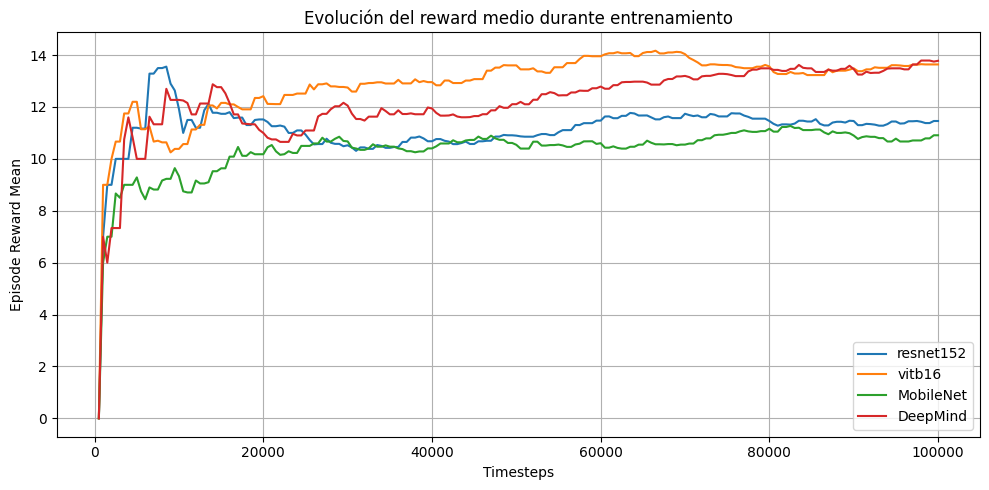

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(resnet_run["step"], resnet_run["episode_reward_mean"], label="resnet152")
plt.plot(vitb16_run["step"], vitb16_run["episode_reward_mean"], label="vitb16")
plt.plot(mobilenet_run["step"], mobilenet_run["episode_reward_mean"], label="MobileNet")
plt.plot(deepmind_run["step"], deepmind_run["episode_reward_mean"], label="DeepMind")

plt.xlabel("Timesteps")
plt.ylabel("Episode Reward Mean")
plt.title("Evolución del reward medio durante entrenamiento")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Aparentemente el mejor rendimiento en corto tiempo lo obtiene vit16b, seguido por Deepmind que lo supero en sus etapas finales. Sin embargo, se debe calcular el tiempo de entrenamiento para determinar cuál es el más eficiente.

In [46]:
# los timesteps dividido por el tiempo total de entrenamiento en segundos
resnet_time = 1e5 / (get_duration(resnet_run_id) / 1e3)
vitb16_time = 1e5 / (get_duration(vitb16_run_id) / 1e3)
mobilenet_time = 1e5 / (get_duration(mobilenet_run_id) / 1e3)
deepmind_time = 1e5 / (get_duration(deepmind_run_id) / 1e3)

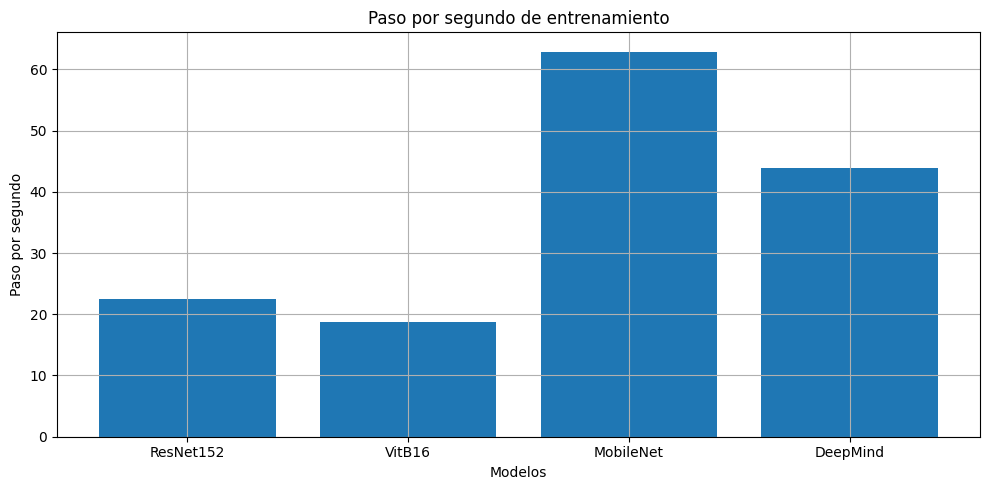

In [48]:
plt.figure(figsize=(10, 5))
plt.bar(["ResNet152", "VitB16", "MobileNet", "DeepMind"], [resnet_time, vitb16_time, mobilenet_time, deepmind_time])
plt.xlabel("Modelos")
plt.ylabel("Paso por segundo")
plt.title("Paso por segundo de entrenamiento")
plt.grid()
plt.tight_layout()
plt.show()

De esta manera eligiendo por velocidad de entrenamiento a deepmind en comparación de vitb16, ya que este pese a tener buena recompensa, sus tiempos de entrenamiento serán muy altos.

Cabe aclarar que como se menciona anteriormente todas estas pruebas se realizan sin establecer el rango de píxeles de 0 a 1, ya que en esos casos no se logra entrenar el modelo. Ya que se realizan varias pruebas con diferentes hiperparametros con este procesamiento como se puede apreciar a continuación.

## 4.2 Pruebas con datos normalizados

In [108]:
failed_run = {
    "custom_DeepMind_v2_4_RMS_pen":"4d07242cd3c74cd0afa66e5a661dc034",
    "custom_DeepMind_v3_4":"adba373efc2c4adf9d6a74b759bf205e",
    "custom_DeepMind_v3_4_2":"6c61b265380040718c3851c8e4126d8b",
    "custom_DeepMind_v3_4_3":"adba373efc2c4adf9d6a74b759bf205e",
}

In [109]:
failed_runs = {name : get_metric_history(run_id, "episode_reward_mean") for name, run_id in failed_run.items()}

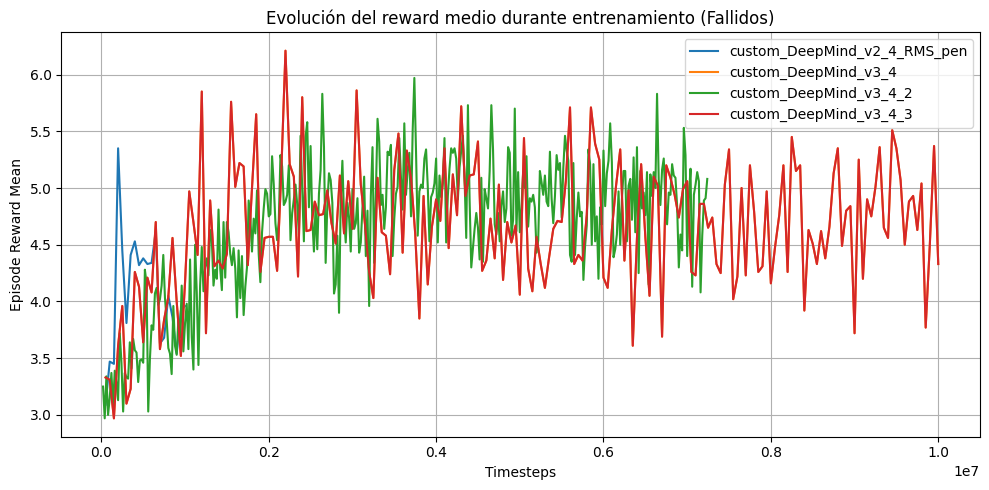

In [110]:
plt.figure(figsize=(10, 5))
for name, run in failed_runs.items():
    plt.plot(run["step"], run["episode_reward_mean"], label=name)
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward Mean")
plt.title("Evolución del reward medio durante entrenamiento (Fallidos)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [111]:
def get_hiperparameters(run_id):
    run = client.get_run(run_id)
    params = run.data.params
    return {k: v for k, v in params.items()}

In [112]:
hiper_params = {name: get_hiperparameters(run_id) for name, run_id in failed_run.items()}

for name, params in hiper_params.items():
    print(f"{name}:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    print()

custom_DeepMind_v2_4_RMS_pen:
  frame_skip: 4
  learning_rate: 0.00025
  gamma: 0.99
  exploration_fraction: 0.1
  exp_name: custom_DeepMind_v2_4_RMS_pen
  total_timesteps: 1000000
  buffer_size: 1000000
  optimizer_class: RMSprop
  exploration_initial_eps: 1.0
  n_stack: 4
  env_name: SpaceInvadersNoFrameskip-v4
  file_name: models/custom_DeepMind_v3_4_RMS_pen.zip
  target_update_interval: 1000
  learning_starts: 10000
  batch_size: 32
  penalized_repeat: 0.25
  num_episodes: 100
  exploration_final_eps: 0.01

custom_DeepMind_v3_4:
  frame_skip: 4
  learning_rate: 0.00025
  gamma: 0.99
  exploration_fraction: 0.1
  exp_name: custom_DeepMind_v3_4
  total_timesteps: 10000000
  buffer_size: 1000000
  optimizer_class: RMSprop
  exploration_initial_eps: 1.0
  n_stack: 4
  env_name: SpaceInvadersNoFrameskip-v4
  file_name: models/custom_DeepMind_v3_4.zip
  target_update_interval: 10000
  learning_starts: 50000
  batch_size: 32
  penalized_repeat: 0.25
  num_episodes: 100
  exploration_final

De los cuales las acciones de cada modelo se pueden observar a continuación:

In [113]:
actions = [f"action_{i}_percentage" for i in range(6)]
def get_actions(run_id):
    actions_list = [get_metric_history(run_id, action) for action in actions]
    return actions_list


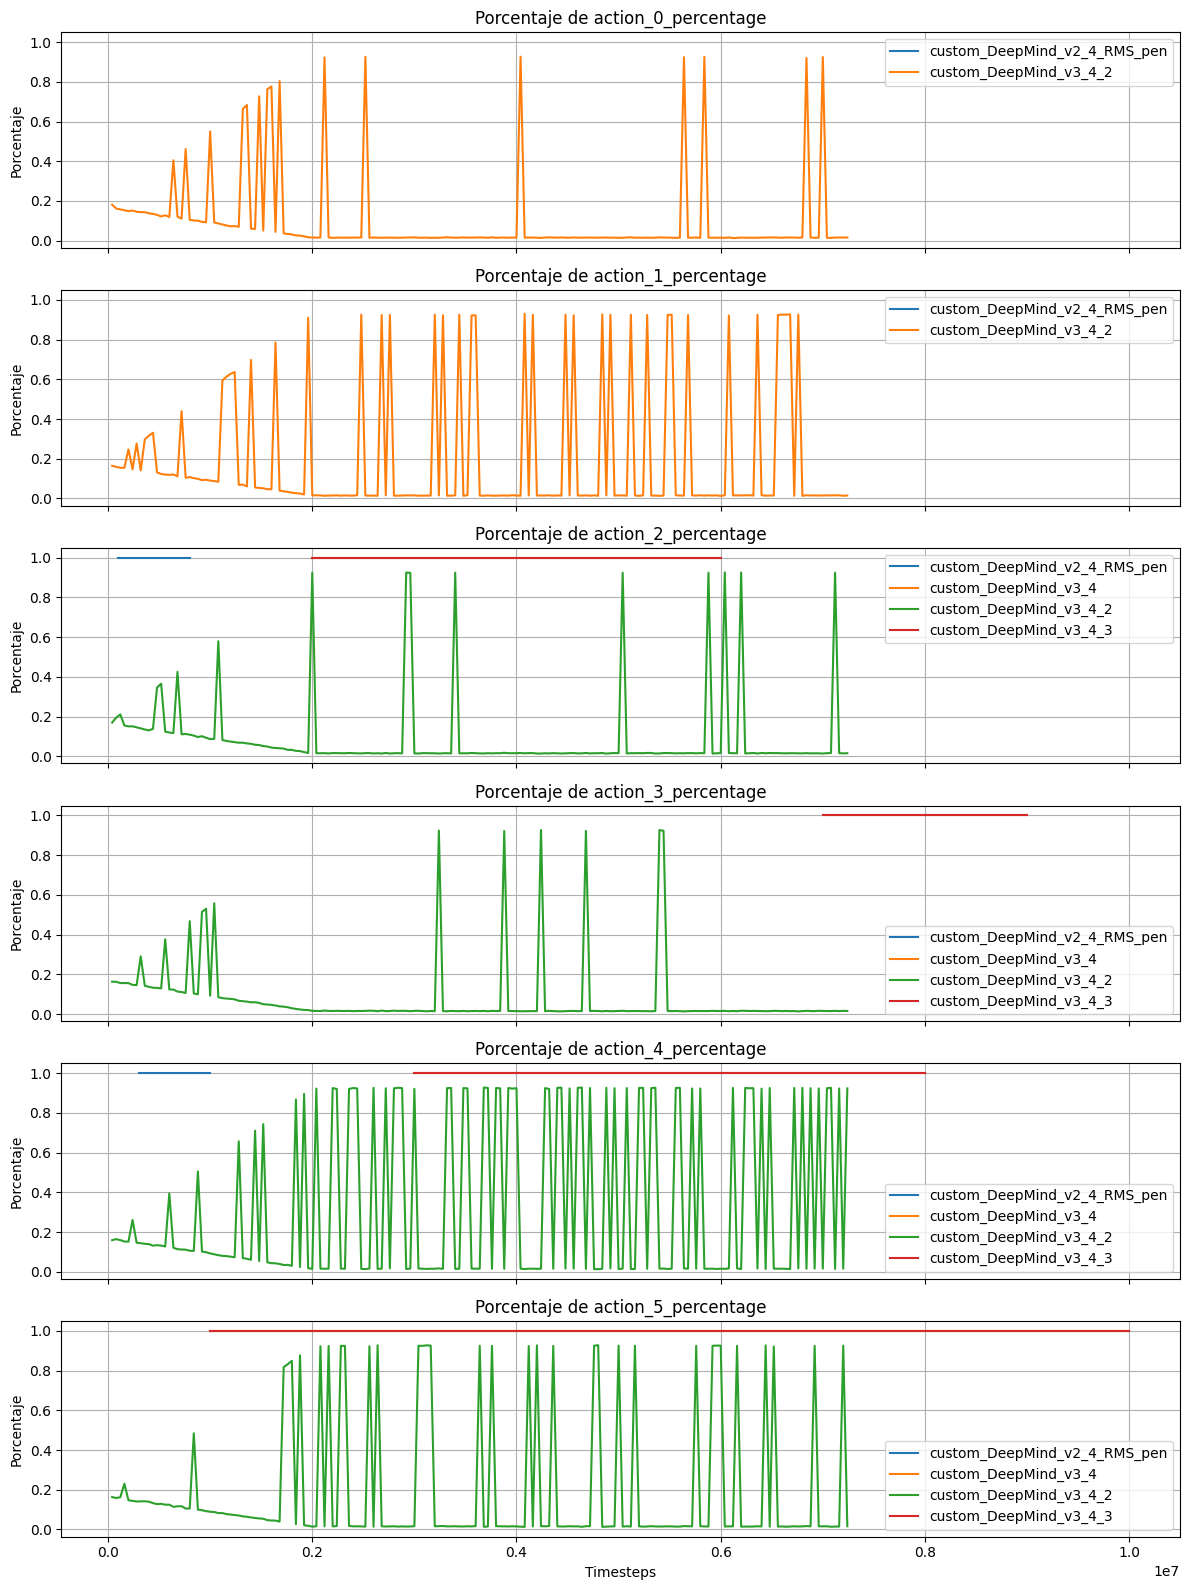

In [114]:
actions_runs = {name: get_actions(run_id) for name, run_id in failed_run.items()}

actions_data = actions_runs["custom_DeepMind_v2_4_RMS_pen"]

model_names = list(actions_runs.keys())
num_actions = len(actions)
fig, axes = plt.subplots(num_actions, 1, figsize=(12, 16), sharex=True)
for i, ax in enumerate(axes):
    for model_name in model_names:
        action_df = actions_runs[model_name][i]
        if action_df.empty:
            continue
        ax.plot(action_df["step"], action_df[actions[i]], label=model_name)
    ax.set_title(f"Porcentaje de {actions[i]}")
    ax.set_ylabel("Porcentaje")
    ax.legend()
    ax.grid()
axes[-1].set_xlabel("Timesteps")
plt.tight_layout()
plt.show()


Así observando el mismo patron independiente de las variaciones de hiperparametros o penalizaciones de repetición el modelo no logra aprender cuando los valores de los píxeles se encuentran entre 0 y 1, así que en las pruebas consiguientes se usan sus valores de 0 a 255.

## 4.3 Elección de hiperparámetros

De esta forma, se eligen los hiperparametros basandonos en modelos preentrenados de Deepmind (Mnih et al., 2015) y de los encontrados en la colección de stable baselines 3 (sb3 (Stable-Baselines3), 2022).




In [104]:
# Función para concatenar métricas de varias runs secuenciales
def concatenar_runs(run_ids, metric_names):
    dfs = []
    step_offset = 0

    for run_id in run_ids:
        df_parts = []
        for metric in metric_names:
            df_metric = get_metric_history(run_id, metric)
            df_metric.set_index("step", inplace=True)
            df_parts.append(df_metric)

        df = pd.concat(df_parts, axis=1).reset_index()

        # Ajustar los steps para que continúen secuencialmente
        df["step"] = df["step"] + step_offset
        step_offset = df["step"].iloc[-1] + 1

        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

Así con una aproximación inicial de 10 M de timesteps, se entrenan modelos de DQN, QRDQN, A2C y PPO con los siguientes hiperparámetros:

In [107]:
dqn_run_id = "914f23523dcf4539966b840d8b4d6955"
df_dqn_concat = concatenar_runs([dqn_run_id], ["episode_reward_mean", "episode_reward_std"])
hiper_params = get_hiperparameters(dqn_run_id)

print("Hiperparámetros del modelo DQN:")
for key, value in hiper_params.items():
    print(f"{key}: {value}")

Hiperparámetros del modelo DQN:
frame_skip: 4
learning_rate: 0.0001
gamma: 0.99
exploration_fraction: 0.1
exp_name: custom_DeepMind_v3_4
env_var: 1
total_timesteps: 10000000
buffer_size: 10000
optimizer_class: Adam
exploration_initial_eps: 1.0
n_stack: 4
env_name: SpaceInvadersNoFrameskip-v4
file_name: models/custom_DeepMind_v3_4.zip
target_update_interval: 1000
learning_starts: 100000
batch_size: 32
penalized_repeat: 0.25
num_episodes: 100
exploration_final_eps: 0.01


Cabe resaltar que en el caso de modelos como DQN, se usa un porcentaje de exploración del 10 % de los timesteps con un decremento lineal desde 1.0 hasta 0.01, esto con la intención de que al inicio el modelo explore el entorno y luego explote y refine las mejores acciones o tácticas aprendidas.

Y en el caso de DQN a diferencia del artículo principal (Mnih et al., 2015) se usa Adam en vez de RMSprop, ya que se encuentra que da más estabilidad al entrenamiento.

In [116]:
# --- QRDQN (una única run) ---
qrdqn_run_id = "78cd4d25f19e4ed996d0d864f1969eb4"
df_qrdqn_concat = concatenar_runs([qrdqn_run_id], ["episode_reward_mean", "episode_reward_std"])
hiper_params = get_hiperparameters(qrdqn_run_id)

print("Hiperparámetros del modelo QRDQN:")
for key, value in hiper_params.items():
    print(f"{key}: {value}")

Hiperparámetros del modelo QRDQN:
frame_skip: 4
exploration_fraction: 0.025
exp_name: custom_DeepMind_v3_4_qrdqn
env_var: 1
total_timesteps: 10000000
optimizer_class: RMSprop
exploration_initial_eps: 1.0
n_stack: 4
env_name: SpaceInvadersNoFrameskip-v4
file_name: models/custom_DeepMind_v3_4_qrdqn.zip
target_update_interval: 10000
learning_starts: 50000
batch_size: 32
penalized_repeat: 0.25
num_episodes: 100
exploration_final_eps: 0.1


En este caso la fracción de entrenamiento es menor que el DQN, ya que al usar QRDQN se busca una mayor estabilidad de entrenamiento y una mejor convergencia, porque se usa una aproximación de la distribución de las recompensas en vez de un valor único como en DQN. Esto permite al modelo aprender de manera más robusta y evitar problemas de sobreajuste a acciones específicas (Dabney et al., 2017).

In [118]:
# --- Concatenar PPO (de 0 a 29.7M timesteps) ---
ppo_run_ids = [
    "d5750967396d4e5b97e4ef2e72979f21",  # 0 a 10M
    "95c2decd982545278b2929f016ad6d44",  # 10M a 17.5M
    "fcb164f883fe4ab2ad719a0fe176d493"   # 17.5M a 29.7M
]

df_ppo_concat = concatenar_runs(ppo_run_ids, ["episode_reward_mean", "episode_reward_std"])

hiper_params = get_hiperparameters(ppo_run_ids[0])
print("Hiperparámetros del modelo PPO:")
for key, value in hiper_params.items():
    print(f"{key}: {value}")


Hiperparámetros del modelo PPO:
clip_range: <function get_linear_fn.<locals>.func at 0x7f484d82e5c0>
frame_skip: 4
learning_rate: <function get_linear_fn.<locals>.func at 0x7f484d82e520>
exp_name: deepmind_zoo_imp_ppo
env_var: 8
ent_coef: 0.01
total_timesteps: 10000000
vf_coef: 0.5
n_steps: 128
n_stack: 4
n_epochs: 4
env_name: SpaceInvadersNoFrameskip-v4
file_name: models/deepmind_zoo_imp_ppo.zip
batch_size: 256
num_episodes: 100


En los caos de los algoritmos on-policy como A2C y PPO se aprovecha la paralelización de los entornos lo que le da mayor velocidad de convergencia comparada con los off-policy. En el caso de PPO se adiciona el cliping con una función lineal decreciente de 0.1 a 0.01, esto para evitar que el modelo se desestabilice al actualizar las políticas y así mejorar la estabilidad del entrenamiento, facilitando la exploración y la explotación de acciones (Schulman et al., 2017).

De manera similar para la elección del coeficiente de entropía, se usa un valor de 0.01, lo que permite al modelo explorar más acciones y evitar caer en políticas subóptimas, ya que fomenta la exploración de acciones menos probables (Schulman et al., 2017). Y para el caso del coeficiente de valor se usa un valor de 0.5, lo que permite al modelo no desviarse de la política actual lo que ayuda a la estabilidad de entrenamiento (Schulman et al., 2017).

Además de en este caso usar como optimizador RMSprop en vez de adam con una caida lineal de 2.5e-4 a 1e-5 con el fin de que al final del entrenamiento el modelo solo se concentre en explotar las mejores acciones aprendidas.

In [120]:
# --- Concatenar A2C (de 0 a 36.6M timesteps) ---
a2c_run_ids = [
    "196919f796824d74aefce46a20d0c44f",  # 0 a 10M
    "d29144d2e70447c5887a0bcd125c2b1a",  # 10M a 16.6M
    "f445012c13154edcbadfe3ed0f7187ef"   # 16.6M a 36.6M
]

df_a2c_concat = concatenar_runs(a2c_run_ids, ["episode_reward_mean", "episode_reward_std"])
hiper_params = get_hiperparameters(a2c_run_ids[0])

print("Hiperparámetros del modelo A2C:")
for key, value in hiper_params.items():
    print(f"{key}: {value}")

Hiperparámetros del modelo A2C:
normalize: False
frame_skip: 4
learning_rate: 0.001
exp_name: deepmind_zoo_imp_a2c
env_var: 16
ent_coef: 0.01
total_timesteps: 10000000
vf_coef: 0.25
n_stack: 1
env_name: SpaceInvadersNoFrameskip-v4
file_name: models/deepmind_zoo_imp_a2c.zip
num_episodes: 100


En el caso de A2C, se usa solo una imagen en vez de un set de imágenes ya que se encuentra que da mejores resultados que con un stack de estas. Con la unica modificación de hiperparametros es el coeficiente de valor que igual que PPO se usa para controlar la política y el valor mejorando la estabilidad al ser políticas paralelizables.

In [137]:
stack_4_a2c_run = "9b35fcfdbb69459a8bd4ec429b0ec3cb"
data = get_metric_history(stack_4_a2c_run, "episode_reward_mean")
print(client.get_run(stack_4_a2c_run).info.run_name)
print("máximo valor obtenido con 4 stacks en ppo", max(data.episode_reward_mean), "con un total de episodios de", max(data.step))

A2C_Run_deepmind_zoo_imp_a2c
máximo valor obtenido con 4 stacks en ppo 4.22 con un total de episodios de 3200000


## 4.4 Comparación de modelos

Evolución del reward medio durante el entrenamiento

Se muestra la evolución del `episode_reward_mean` por timesteps para cada algoritmo. Esta gráfica permite observar el ritmo y la capacidad de aprendizaje a lo largo del entrenamiento.


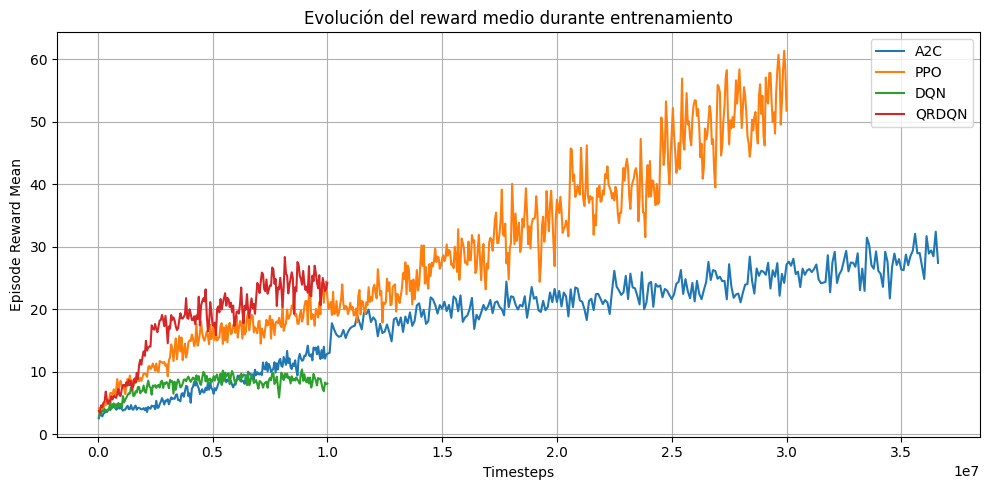

In [138]:
plt.figure(figsize=(10, 5))
plt.plot(df_a2c_concat["step"], df_a2c_concat["episode_reward_mean"], label="A2C")
plt.plot(df_ppo_concat["step"], df_ppo_concat["episode_reward_mean"], label="PPO")
plt.plot(df_dqn_concat["step"], df_dqn_concat["episode_reward_mean"], label="DQN")
plt.plot(df_qrdqn_concat["step"], df_qrdqn_concat["episode_reward_mean"], label="QRDQN")

plt.xlabel("Timesteps")
plt.ylabel("Episode Reward Mean")
plt.title("Evolución del reward medio durante entrenamiento")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Estabilidad del entrenamiento (episode_reward_std)

Se compara la desviación estándar del reward por episodio para cada algoritmo. Esto permite evaluar la **consistencia** del aprendizaje, donde un `std` más bajo indica comportamiento más estable.


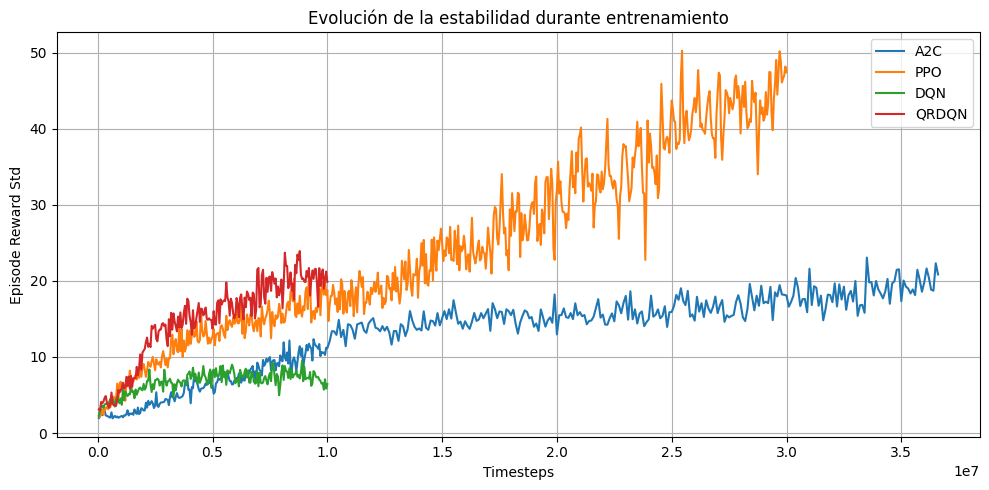

In [139]:
plt.figure(figsize=(10, 5))
plt.plot(df_a2c_concat["step"], df_a2c_concat["episode_reward_std"], label="A2C")
plt.plot(df_ppo_concat["step"], df_ppo_concat["episode_reward_std"], label="PPO")
plt.plot(df_dqn_concat["step"], df_dqn_concat["episode_reward_std"], label="DQN")
plt.plot(df_qrdqn_concat["step"], df_qrdqn_concat["episode_reward_std"], label="QRDQN")

plt.xlabel("Timesteps")
plt.ylabel("Episode Reward Std")
plt.title("Evolución de la estabilidad durante entrenamiento")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Comparación entre rendimiento en entrenamiento y test

Aquí se evalúa si el comportamiento observado durante el entrenamiento (`episode_reward_mean`) se mantiene en evaluación (`test_reward`).


In [141]:
# Diccionario con los run_id finales de cada algoritmo
runs_finales = {
    "DQN": "914f23523dcf4539966b840d8b4d6955",
    "QRDQN": "78cd4d25f19e4ed996d0d864f1969eb4",
    "A2C": "f445012c13154edcbadfe3ed0f7187ef",  # última run concatenada
    "PPO": "fcb164f883fe4ab2ad719a0fe176d493"   # última run concatenada
}

datos = []

for nombre, run_id in runs_finales.items():
    # Obtener historia de métricas
    history_train = client.get_metric_history(run_id, "episode_reward_mean")
    history_test = client.get_metric_history(run_id, "test_reward")

    # Convertir a listas de valores
    train_values = [m.value for m in history_train]
    test_values = [m.value for m in history_test]

    if train_values and test_values:
        max_train = max(train_values)
        max_test = max(test_values)
        diff = max_train - max_test
        datos.append({
            "Algoritmo": nombre,
            "Max Train Reward": round(max_train, 2),
            "Max Test Reward": round(max_test, 2),
            "Diferencia (Max Train - Max Test)": round(diff, 2)
        })

# Mostrar tabla
df_comparacion = pd.DataFrame(datos)
df_comparacion.sort_values("Algoritmo", inplace=True)
df_comparacion.reset_index(drop=True, inplace=True)
df_comparacion



,Algoritmo,Max Train Reward,Max Test Reward,Diferencia (Max Train - Max Test)
0,A2C,32.41,77.88,-45.47
1,DQN,10.38,11.49,-1.11
2,PPO,61.36,70.28,-8.92
3,QRDQN,28.36,33.14,-4.78


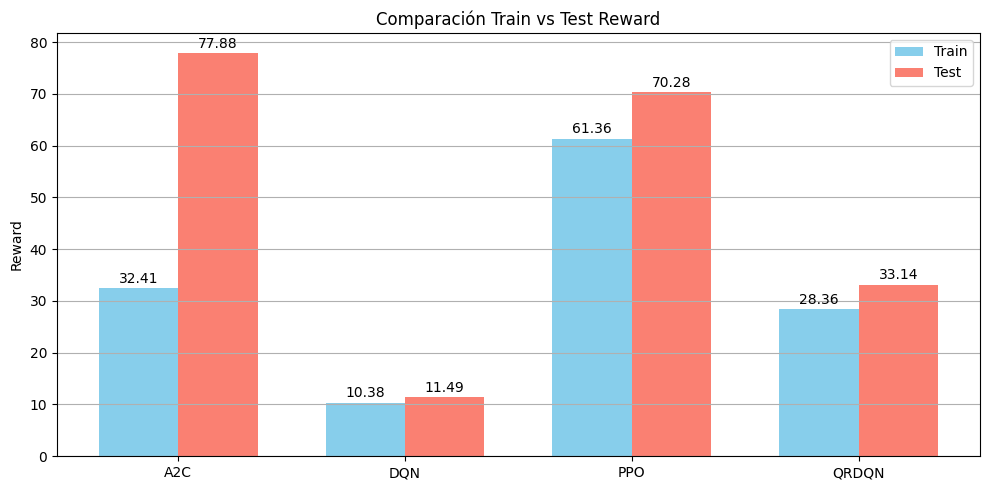

In [144]:
# Crear la gráfica
algoritmos = df_comparacion["Algoritmo"]
train = df_comparacion["Max Train Reward"]
test = df_comparacion["Max Test Reward"]
diff = df_comparacion["Diferencia (Max Train - Max Test)"]

x = np.arange(len(algoritmos))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, train, width, label="Train", color="skyblue")
plt.bar(x + width/2, test, width, label="Test", color="salmon")

for i in range(len(x)):
    plt.text(x[i] - width/2, train[i] + 1, f"{train[i]}", ha='center')
    plt.text(x[i] + width/2, test[i] + 1, f"{test[i]}", ha='center')

plt.xticks(x, algoritmos)
plt.ylabel("Reward")
plt.title("Comparación Train vs Test Reward")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Comparación de episodios por segundo

In [159]:
ppo_time = int(client.get_run(runs_finales["PPO"]).data.params["total_timesteps"]) / (get_duration(runs_finales["PPO"]) / 1e3)
a2c_time = int(client.get_run(runs_finales["A2C"]).data.params["total_timesteps"]) / (get_duration(runs_finales["A2C"]) / 1e3)
dqn_time = int(client.get_run(runs_finales["DQN"]).data.params["total_timesteps"]) / (get_duration(runs_finales["DQN"]) / 1e3)
qrdqn_time = int(client.get_run(runs_finales["QRDQN"]).data.params["total_timesteps"]) / (get_duration(runs_finales["QRDQN"]) / 1e3)

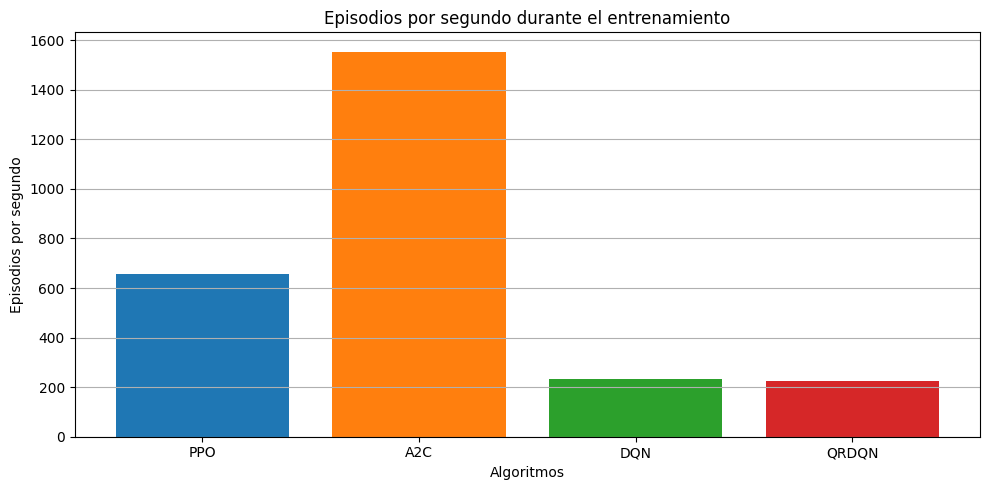

In [160]:
plt.figure(figsize=(10, 5))
plt.bar(["PPO", "A2C", "DQN", "QRDQN"], [ppo_time, a2c_time, dqn_time, qrdqn_time], color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
plt.xlabel("Algoritmos")
plt.ylabel("Episodios por segundo")
plt.title("Episodios por segundo durante el entrenamiento")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Adicionalmente, se evaluó, la capacidad de paralelización de QRDQN y DQN, aunque en ambos casos no se lograba una mejora significativa, esto principalmente debido a los cambios de política drasticos y su falta de control frente a esto.

In [161]:
failed_paralelization = {
    "Run_custom_DeepMind_v3_4_qrdqn":"fd952e661fd34080b943e4555a32fe98",
    "custom_DeepMind_v3_4_dqn":"e68170d3002f41529497b13366d51e06",
}


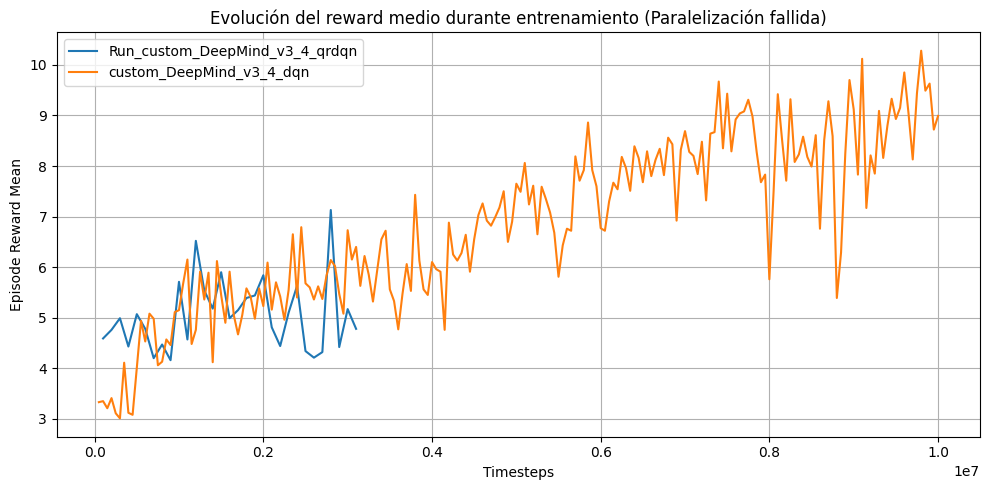

In [163]:
failed_paralelization_runs = {name: get_metric_history(run_id, "episode_reward_mean") for name, run_id in failed_paralelization.items()}


plt.figure(figsize=(10, 5))
for name, run in failed_paralelization_runs.items():
    plt.plot(run["step"], run["episode_reward_mean"], label=name)
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward Mean")
plt.title("Evolución del reward medio durante entrenamiento (Paralelización fallida)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 5. Conclusiones


PPO logra el mejor rendimiento general. A2C tiene un crecimiento más lento y controlado, reflejando un aprendizaje más estable pero menos ambicioso.

Estos resultados son coherentes con lo reportado por Schulman et al. (2017), donde comenta que rinde mejor en Atari que A2C. Y con lo demostrado en (Mnih et al. 2016) , donde se evindecnia que A2C se caracteriza por su estabilidad durante el entrenamiento.

DQN y QRDQN parecen limitarse en capacidad de mejora, estabilizándose pronto sin llegar al rendimiento de PPO o A2C. Siendo dentro los resultados visiblemente mejor QRDQN que DQN

La superioridad de QRDQN sobre DQN está respaldada por métricas de rendimiento significativamente más altas y por una sólida base teórica y ventajas algorítmicas, como se desprende de (Dabney et al. 2017).

No se descarta que QRDQN pudiera superar a los algoritmos on-policy (como PPO o A2C) si se entrenara durante más tiempo.
Sin embargo, su alto consumo de memoria, debido al uso de un replay buffer distribuido (hasta 50 GB por 1 millón de timesteps), lo hace poco viable para entrenamientos prolongados dentro de las restricciones de este proyecto.

En contraste, los algoritmos on-policy como PPO y A2C no requieren almacenar experiencias pasadas, lo que reduce significativamente su uso de memoria (en torno a 5–10 GB). Además, ambos son fácilmente paralelizables, lo que permite ejecutar múltiples entornos simultáneamente y acumular más timesteps en menos tiempo real.
Por ejemplo, mientras 10M timesteps con DQN o QRDQN pueden tardar hasta 10 horas, PPO y A2C pueden alcanzar ese mismo volumen en 2 horas o menos gracias a su diseño paralelo.

Por estas razones prácticas —principalmente el equilibrio entre coste computacional, tiempo de entrenamiento y estabilidad—, se optó por priorizar el uso y análisis extendido de PPO y A2C.

PPO es el algoritmo más recomendable, por su alto rendimiento medio, buen uso de recursos y capacidad de generalización.
A2C es una buena segunda opción.
Se desaconseja el uso de DQN en este entorno sin cambios sustanciales en diseño o configuración.


## Referencias

- Dabney, W., Rowland, M., Bellemare, M. G., & Munos, R. (2017). Distributional Reinforcement Learning with Quantile Regression (No. arXiv:1710.10044). arXiv. https://doi.org/10.48550/arXiv.1710.10044
- Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., Graves, A., Riedmiller, M., Fidjeland, A. K., Ostrovski, G., Petersen, S., Beattie, C., Sadik, A., Antonoglou, I., King, H., Kumaran, D., Wierstra, D., Legg, S., & Hassabis, D. (2015). Human-level control through deep reinforcement learning. Nature, 518(7540), 529-533. https://doi.org/10.1038/nature14236
- Sb3 (Stable-Baselines3). (2022, octubre 11). https://huggingface.co/sb3/models
- Schulman, J., Wolski, F., Dhariwal, P., Radford, A., & Klimov, O. (2017). Proximal Policy Optimization Algorithms (No. arXiv:1707.06347). arXiv. https://doi.org/10.48550/arXiv.1707.06347
